# Training and evaluation of a SVCL classification model 
In this script a support vector machines with linear kernel classification model is trained and evaluated with different subjects.

## Import the libraries

In [1]:
import os
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

## Create some functions

In [2]:
def evaluate_model_predictions(real_classes, predicted_classes, subject) :
    #Calculate the confusion matrix
    cm = confusion_matrix(real_classes, predicted_classes)
    #Show the co-occurrence matrix
    plt.figure(figsize = (8,6))
    sns.heatmap(cm, square=True, annot=True, annot_kws={"size": 20}, cmap=plt.cm.Blues, cbar=False,
                xticklabels=['Resting', 'Right','Left'], yticklabels=['Resting', 'Right', 'Left'])
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.title('Subject %d' % (subject), fontsize=18)
    #Calculate true positives and false negatives for each class
    tp0 = cm[0,0]
    tp1 = cm[1,1]
    tp2 = cm[2,2]
    tn0 = cm[1,1] + cm[1,2] + cm[2,1] + cm[2,2]
    tn1 = cm[0,0] + cm[2,0] + cm[0,2] + cm[2,2]
    tn2 = cm[0,0] + cm[1,0] + cm[0,1] + cm[1,1]
    fp0 = cm[1,0] + cm[2,0]
    fp1 = cm[0,1] + cm[2,1]
    fp2 = cm[0,2] + cm[1,2]
    fn0 = cm[0,1] + cm[0,2]
    fn1 = cm[1,0] + cm[1,2]
    fn2 = cm[2,0] + cm[2,1]
    #Calculate and print the metrics
    accuracy = (tp0+tp1+tp2)/np.sum(cm)
    print('Total accuracy:', accuracy)
    print('------------------------------------------')
    precision0 = tp0/(tp0+fp0)
    precision1 = tp1/(tp1+fp1)
    precision2 = tp2/(tp2+fp2)
    print('Precision for resting state:', precision0)
    print('Precision for right movement:', precision1)
    print('Precision for left movement:', precision2)
    print('------------------------------------------')
    sensitivity0 = tp0/(tp0+fn0)
    sensitivity1 = tp1/(tp1+fn1)
    sensitivity2 = tp2/(tp2+fn2)
    print('Sensitivity (true positive rate) for resting state:', sensitivity0)
    print('Sensitivity (true positive rate) for right movement:', sensitivity1)
    print('Sensitivity (true positive rate) for left movement:', sensitivity2)
    print('------------------------------------------')
    specificity0 = tn0/(tn0+fp0)
    specificity1 = tn1/(tn1+fp1)
    specificity2 = tn2/(tn2+fp2)
    print('Specificity (true negative rate) for resting state:', specificity0)
    print('Specificity (true negative rate) for right movement:', specificity1)
    print('Specificity (true negative rate) for left movement:', specificity2)
    print('------------------------------------------')
    f1_0 = 2*(precision0*sensitivity0)/(precision0+sensitivity0)
    f1_1 = 2*(precision1*sensitivity1)/(precision1+sensitivity1)
    f1_2 = 2*(precision2*sensitivity2)/(precision2+sensitivity2)
    print('F1 for resting state:', f1_0)
    print('F1 for right movement:', f1_1)
    print('F1 for left movement:', f1_2)
    print('------------------------------------------')

In [3]:
def plot_roc_curve(y_test, y_prob, subject) :
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    classes = ['Resting','Right','Left']
    #Compute and plot ROC curve and ROC area for each class
    plt.figure(figsize = (8,6))
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        label = 'ROC curve of ' + classes[i] + ' (area =%.2f)' % (roc_auc)
        plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    #plt.title('ROC Curves for subject %d' % (subject), fontisize=18)
    plt.legend(loc="lower right")
    plt.show()

## Read the features and labels from all the subjects

In [4]:
#read subjects files and merge them
files = os.listdir('Subjects data')
features_all = pd.read_csv('Subjects data/' + files[0], encoding='latin1')
files.pop(0)
for f in files :
    features_subject = pd.read_csv('Subjects data/' + f, encoding='latin1')
    frames = [features_all, features_subject]
    features_all = pd.concat(frames)
#features_all.index = [features_all['Subject'], features_all['Epoch']]
subjects_idx = features_all['Subject'].values
#features_all = features_all.drop(['Subject','Epoch'], axis = 1)
features_all

,Subject,Epoch,Mean_FC5,Variance_FC5,Kurtosis_FC5,Mean_FC3,Variance_FC3,Kurtosis_FC3,Mean_FC1,Variance_FC1,...,PLV_CP1_CP2,PLV_CP1_CP4,PLV_CP1_CP6,PLV_CPz_CP2,PLV_CPz_CP4,PLV_CPz_CP6,PLV_CP2_CP4,PLV_CP2_CP6,PLV_CP4_CP6,Label
0,1,1,0.077105,7.357580,2.809176,0.382332,7.589385,3.297552,0.464633,7.700149,...,0.318132,0.073507,0.323108,0.669452,0.247354,0.067815,0.685624,0.365035,0.772310,1
1,1,2,-0.018304,7.029542,2.842915,0.184697,6.991603,3.060431,0.281971,7.484742,...,0.470648,0.123157,0.181453,0.699222,0.302571,0.062673,0.705291,0.361569,0.726673,2
2,1,3,-0.319861,6.399684,3.428581,-0.346442,6.964995,2.777844,-0.256384,8.132662,...,0.580862,0.386278,0.231118,0.773177,0.498727,0.242550,0.764621,0.475057,0.770152,1
3,1,4,0.036567,8.415375,2.555121,0.150948,9.348971,3.053070,0.207301,8.933164,...,0.607181,0.256862,0.167798,0.806269,0.438541,0.089317,0.747473,0.330642,0.694656,2
4,1,5,0.257114,13.767046,2.879540,0.157239,14.221320,2.764797,-0.017693,13.340810,...,0.464897,0.257998,0.146752,0.819921,0.607017,0.364591,0.854306,0.557560,0.742894,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,44,256,-0.347318,11.215760,2.415819,-0.551029,13.194753,2.405359,-0.656948,12.642553,...,0.080379,0.140109,0.308763,0.595714,0.356431,0.148958,0.845309,0.611503,0.830670,0
256,44,257,0.221785,12.573679,3.445813,0.237528,11.310268,3.638090,0.239306,11.290607,...,0.266919,0.165629,0.418936,0.611298,0.252375,0.062959,0.743924,0.390819,0.758761,0
257,44,258,-0.429369,7.199075,3.063733,-0.496420,8.957319,3.198463,-0.582399,9.467059,...,0.578182,0.322126,0.422456,0.720966,0.303902,0.250078,0.694467,0.191094,0.554233,0
258,44,259,-0.945257,21.763986,6.206397,-0.971078,17.039679,6.818231,-0.958857,15.633321,...,0.444469,0.202010,0.083466,0.758260,0.527970,0.244990,0.844094,0.562038,0.789984,0


- Select the features according to the previously result from RFE method

In [5]:
features_names = ['PSD_FC1_D3', 'PSD_Cz_D3', 'PSD_CP1_D3', 'PSD_CP2_D3', 'PLV_FC5_FC1',
                   'PLV_FC5_CP5', 'PLV_FC3_C1', 'PLV_FC3_CP1', 'PLV_FC1_FC2', 'PLV_FC1_C3',
                   'PLV_FC1_C2', 'PLV_FC1_CPz', 'PLV_C5_CP6', 'PLV_C3_C1', 'PLV_Cz_C4',
                   'PLV_C2_C4', 'PLV_CP5_CP3', 'PLV_CP5_CP6', 'PLV_CP3_CP2', 'PLV_CP4_CP6']

## Split the subjects into training and test

In [6]:
#Select randomly subjects for train and test
subjects = np.unique(subjects_idx)
subjects_train = [15, 12, 21, 4, 10, 44, 3, 18, 29, 20, 7, 19, 11, 2, 28, 5, 8, 16, 6]
subjects_test = [1, 13, 17, 14, 9]
subjects_train, subjects_test

([15, 12, 21, 4, 10, 44, 3, 18, 29, 20, 7, 19, 11, 2, 28, 5, 8, 16, 6],
 [1, 13, 17, 14, 9])

- Get the training data

In [7]:
train_idx = features_all['Subject'] == subjects_train[0]
features_train = features_all[train_idx]
subjects_train2 = np.delete(subjects_train, 0, axis=None)
for subject in subjects_train2 :
    train_idx = features_all['Subject'] == subject
    frames = [features_train, features_all[train_idx]]
    features_train = pd.concat(frames)
subjects_idx_train = features_train['Subject']
features_train.index = [features_train['Subject'], features_train['Epoch']]
X_train = features_train.drop(['Subject','Epoch'], axis = 1)
X_train = X_train[features_names]
X_train

PSD_FC1_D3  PSD_Cz_D3  PSD_CP1_D3  PSD_CP2_D3  PLV_FC5_FC1  \
Subject Epoch                                                               
15      1        0.034486   0.076231    0.027698    0.044284     0.328939   
        2        0.028806   0.060074    0.028159    0.033061     0.422381   
        3        0.035788   0.073811    0.034063    0.042011     0.404427   
        4        0.029694   0.059838    0.027287    0.037784     0.295600   
        5        0.026469   0.040255    0.024066    0.030912     0.437315   
...                   ...        ...         ...         ...          ...   
6       273      0.242868   0.132700    0.074924    0.114307     0.300043   
        274      0.257755   0.198752    0.089106    0.107626     0.421420   
        275      0.123824   0.128342    0.070091    0.076460     0.503686   
        276      0.515490   0.347935    0.110243    0.164176     0.423568   
        277      0.505996   0.253699    0.108354    0.124724     0.427082   

               PLV_FC5_CP5  PLV_FC3_C1  PLV_FC3_CP1  PLV_FC1_FC2  PLV_FC1_C3  \
Subject Epoch                                                                  
15      1         0.274523    0.666815     0.648738     0.686277    0.700358   
        2         0.201130    0.644448     0.581876     0.576222    0.675428   
        3         0.251832    0.668037     0.626021     0.709359    0.745186   
        4         0.238209    0.560659     0.517382     0.648619    0.649738   
        5         0.303521    0.759739     0.724280     0.659948    0.773086   
...                    ...         ...          ...          ...         ...   
6       273       0.308553    0.650554     0.344405     0.625155    0.542170   
        274       0.219168    0.663909     0.364445     0.601041    0.573837   
        275       0.287101    0.728531     0.537757     0.638831    0.343031   
        276       0.243886    0.620636     0.392398     0.559320    0.509189   
        277       0.267295    0.733090     0.428935     0.745127    0.593039   

               PLV_FC1_C2  PLV_FC1_CPz  PLV_C5_CP6  PLV_C3_C1  PLV_Cz_C4  \
Subject Epoch                                                              
15      1        0.570172     0.507703    0.194724   0.631169   0.327217   
        2        0.454940     0.415534    0.168461   0.617415   0.196764   
        3        0.614729     0.480164    0.042859   0.674037   0.340390   
        4        0.526301     0.508942    0.049900   0.590852   0.317237   
        5        0.603110     0.559794    0.150218   0.774976   0.266988   
...                   ...          ...         ...        ...        ...   
6       273      0.483756     0.487275    0.251002   0.647679   0.298595   
        274      0.399727     0.364564    0.318455   0.719368   0.452053   
        275      0.564578     0.585509    0.345457   0.653562   0.429753   
        276      0.435446     0.433962    0.285531   0.697862   0.278913   
        277      0.669092     0.494826    0.145324   0.749290   0.524799   

               PLV_C2_C4  PLV_CP5_CP3  PLV_CP5_CP6  PLV_CP3_CP2  PLV_CP4_CP6  
Subject Epoch                                                                 
15      1       0.604345     0.425065     0.194597     0.213017     0.794813  
        2       0.591272     0.473716     0.142296     0.210151     0.726290  
        3       0.585532     0.434534     0.250633     0.207092     0.698610  
        4       0.589996     0.376382     0.156909     0.238464     0.709662  
        5       0.557998     0.491774     0.254824     0.117975     0.828787  
...                  ...          ...          ...          ...          ...  
6       273     0.704364     0.621519     0.229030     0.134593     0.709654  
        274     0.815618     0.489901     0.222150     0.351906     0.785686  
        275     0.782901     0.772894     0.322103     0.125312     0.726543  
        276     0.716274     0.652634     0.176325     0.129566     0.699691  
        277     0.763347     0.5754

In [8]:
Y_train = features_train['Label'].values
Counter(Y_train)

Counter({1: 1737, 2: 1701, 0: 1493})

- Get the test data

In [9]:
test_idx = features_all['Subject'] == subjects_test[0]
features_test = features_all[test_idx]
subjects_test2 = np.delete(subjects_test, 0, axis=None)
for subject in subjects_test2 :
    test_idx = features_all['Subject'] == subject
    frames = [features_test, features_all[test_idx]]
    features_test = pd.concat(frames)
subjects_idx_test = features_test['Subject']
features_test.index = [features_test['Subject'], features_test['Epoch']]
X_test = features_test.drop(['Subject','Epoch'], axis = 1)
X_test = X_test[features_names]
X_test

PSD_FC1_D3  PSD_Cz_D3  PSD_CP1_D3  PSD_CP2_D3  PLV_FC5_FC1  \
Subject Epoch                                                               
1       1        0.086664   0.083963    0.092970    0.114292     0.484257   
        2        0.095059   0.091064    0.096780    0.107360     0.374931   
        3        0.106750   0.100655    0.090766    0.103356     0.355464   
        4        0.094363   0.104104    0.117389    0.117265     0.558519   
        5        0.104158   0.092221    0.087931    0.091201     0.582973   
...                   ...        ...         ...         ...          ...   
9       263      0.113542   0.072197    0.057427    0.050536     0.258811   
        264      0.128066   0.079912    0.083043    0.054004     0.358929   
        265      0.128899   0.084458    0.075904    0.076802     0.468202   
        266      0.098970   0.058202    0.051273    0.038706     0.417310   
        267      0.090022   0.057881    0.055523    0.041734     0.207255   

               PLV_FC5_CP5  PLV_FC3_C1  PLV_FC3_CP1  PLV_FC1_FC2  PLV_FC1_C3  \
Subject Epoch                                                                  
1       1         0.409340    0.706897     0.370033     0.651189    0.586365   
        2         0.378246    0.632239     0.361586     0.666060    0.649646   
        3         0.353106    0.685720     0.335658     0.717759    0.651853   
        4         0.244538    0.553517     0.085060     0.579363    0.522678   
        5         0.456529    0.700441     0.273706     0.610447    0.528336   
...                    ...         ...          ...          ...         ...   
9       263       0.532221    0.609925     0.418659     0.664519    0.461894   
        264       0.321260    0.563016     0.385310     0.679616    0.416684   
        265       0.301832    0.697657     0.362905     0.613061    0.548913   
        266       0.538417    0.767497     0.614627     0.620598    0.602608   
        267       0.499802    0.572933     0.314509     0.624005    0.388376   

               PLV_FC1_C2  PLV_FC1_CPz  PLV_C5_CP6  PLV_C3_C1  PLV_Cz_C4  \
Subject Epoch                                                              
1       1        0.427701     0.304971    0.626944   0.717270   0.298653   
        2        0.509595     0.465891    0.657044   0.776927   0.420719   
        3        0.550038     0.424132    0.562358   0.751411   0.521960   
        4        0.254056     0.150095    0.507196   0.757050   0.235753   
        5        0.266067     0.260937    0.650128   0.732707   0.480823   
...                   ...          ...         ...        ...        ...   
9       263      0.545406     0.459361    0.512965   0.577709   0.625764   
        264      0.487965     0.394062    0.146919   0.571722   0.450394   
        265      0.314784     0.145553    0.317181   0.742639   0.259305   
        266      0.324030     0.408026    0.498418   0.768375   0.344466   
        267      0.361577     0.288574    0.401995   0.540456   0.533751   

               PLV_C2_C4  PLV_CP5_CP3  PLV_CP5_CP6  PLV_CP3_CP2  PLV_CP4_CP6  
Subject Epoch                                                                 
1       1       0.661658     0.665249     0.506631     0.047242     0.772310  
        2       0.673993     0.559321     0.489782     0.205185     0.726673  
        3       0.764893     0.622897     0.484027     0.234950     0.770152  
        4       0.571460     0.762745     0.425203     0.343694     0.694656  
        5       0.812188     0.710487     0.531538     0.115385     0.742894  
...                  ...          ...          ...          ...          ...  
9       263     0.857473     0.472799     0.493498     0.206238     0.740253  
        264     0.767267     0.674208     0.120360     0.226058     0.628691  
        265     0.670932     0.720382     0.328391     0.099232     0.804011  
        266     0.760772     0.601093     0.472075     0.122132     0.764448  
        267     0.819633     0.6104

In [10]:
Y_test = features_test['Label'].values
Counter(Y_test)

Counter({1: 471, 2: 466, 0: 383})

## Preprocess the training data
- Standardize and normalize the data

In [11]:
standardizer = StandardScaler()
X_scaled_train = standardizer.fit_transform(X_train)
normalizer = MinMaxScaler(feature_range=(0,1))
X_scaled_train = normalizer.fit_transform(X_scaled_train)
X_scaled_train.shape

(4931, 20)

## Train the SVCL classifier

In [12]:
classifier = SVC(kernel='linear', C=0.1, verbose=True)
classifier.fit(X_scaled_train, Y_train)

[LibSVM]

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

## Evaluate the model on different subjects

- Evaluate on first test subject

In [13]:
#Select the data from the first testing subject
test_idx = features_all['Subject'] == subjects_test[0]
features_test = features_all[test_idx]
features_test.index = [features_test['Subject'], features_test['Epoch']]
X_test = features_test.drop(['Subject','Epoch','Label'], axis = 1)
Y_test = features_test['Label']
X_test.shape, Y_test.shape, Counter(Y_test)

((260, 310), (260,), Counter({1: 88, 2: 84, 0: 88}))

In [14]:
#Preprocess the data
X_test = X_test[features_names]
X_scaled_test = standardizer.transform(X_test)
X_scaled_test = normalizer.fit_transform(X_scaled_test)
X_scaled_test.shape

(260, 20)

---------------------
SVCL classification results (subject 1 )
---------------------
Total accuracy: 0.5307692307692308
------------------------------------------
Precision for resting state: 0.4859154929577465
Precision for right movement: 0.6379310344827587
Precision for left movement: 0.5333333333333333
------------------------------------------
Sensitivity (true positive rate) for resting state: 0.7840909090909091
Sensitivity (true positive rate) for right movement: 0.42045454545454547
Sensitivity (true positive rate) for left movement: 0.38095238095238093
------------------------------------------
Specificity (true negative rate) for resting state: 0.5755813953488372
Specificity (true negative rate) for right movement: 0.877906976744186
Specificity (true negative rate) for left movement: 0.8409090909090909
------------------------------------------
F1 for resting state: 0.5999999999999999
F1 for right movement: 0.5068493150684932
F1 for left movement: 0.4444444444444444
----------

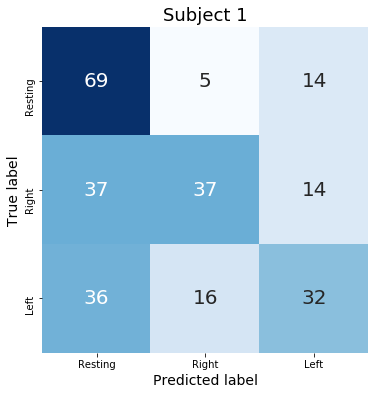

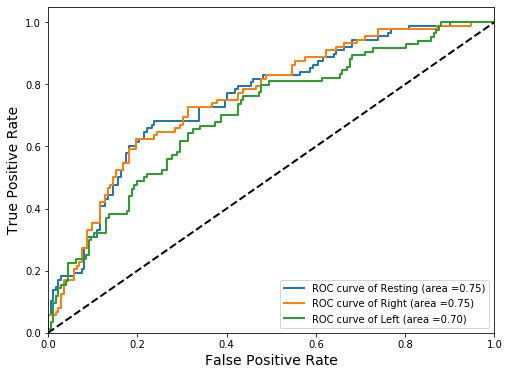

In [15]:
# Predicting the Test set results
y_pred = classifier.predict(X_scaled_test)
y_prob = classifier.decision_function(X_scaled_test)
y_test = Y_test
y_pred = y_pred
#Evaluate the model
print('---------------------')
print('SVCL classification results (subject', subjects_test[0], ')')
print('---------------------')
evaluate_model_predictions(y_test,y_pred, subjects_test[0])
plot_roc_curve(y_test,y_prob, subjects_test[0])

- Evaluate on second subject

In [28]:
#Select the data from the first testing subject
test_idx = features_all['Subject'] == subjects_test[1]
features_test = features_all[test_idx]
features_test.index = [features_test['Subject'], features_test['Epoch']]
X_test = features_test.drop(['Subject','Epoch','Label'], axis = 1)
Y_test = features_test['Label']
X_test.shape, Y_test.shape, Counter(Y_test)

((299, 310), (299,), Counter({2: 99, 1: 100, 0: 100}))

In [29]:
#Preprocess the data
X_test = X_test[features_names]
X_scaled_test = standardizer.transform(X_test)
X_scaled_test = normalizer.fit_transform(X_scaled_test)
X_scaled_test.shape

(299, 20)

---------------------
SVCL classification results (subject 13 )
---------------------
Total accuracy: 0.411371237458194
------------------------------------------
Precision for resting state: 0.38271604938271603
Precision for right movement: 0.5238095238095238
Precision for left movement: 0.5428571428571428
------------------------------------------
Sensitivity (true positive rate) for resting state: 0.93
Sensitivity (true positive rate) for right movement: 0.11
Sensitivity (true positive rate) for left movement: 0.1919191919191919
------------------------------------------
Specificity (true negative rate) for resting state: 0.24623115577889448
Specificity (true negative rate) for right movement: 0.949748743718593
Specificity (true negative rate) for left movement: 0.92
------------------------------------------
F1 for resting state: 0.5422740524781341
F1 for right movement: 0.18181818181818182
F1 for left movement: 0.2835820895522388
------------------------------------------


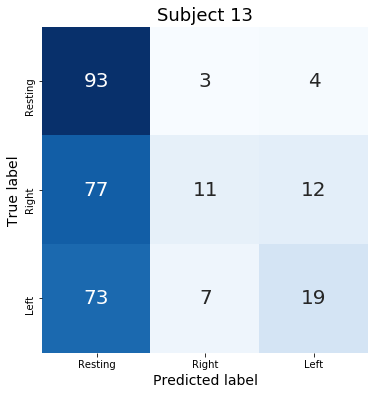

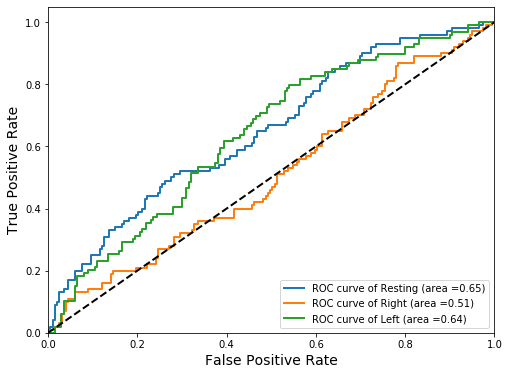

In [30]:
# Predicting the Test set results
y_pred = classifier.predict(X_scaled_test)
y_prob = classifier.decision_function(X_scaled_test)
y_test = Y_test
y_pred = y_pred
#Evaluate the model
print('---------------------')
print('SVCL classification results (subject', subjects_test[1], ')')
print('---------------------')
evaluate_model_predictions(y_test,y_pred, subjects_test[1])
plot_roc_curve(y_test,y_prob, subjects_test[1])

- Evaluate on thrid subject

In [31]:
#Select the data from the first testing subject
test_idx = features_all['Subject'] == subjects_test[2]
features_test = features_all[test_idx]
features_test.index = [features_test['Subject'], features_test['Epoch']]
X_test = features_test.drop(['Subject','Epoch','Label'], axis = 1)
Y_test = features_test['Label']
X_test.shape, Y_test.shape, Counter(Y_test)

((230, 310), (230,), Counter({2: 90, 1: 90, 0: 50}))

In [32]:
#Preprocess the data
X_test = X_test[features_names]
X_scaled_test = standardizer.transform(X_test)
X_scaled_test = normalizer.fit_transform(X_scaled_test)
X_scaled_test.shape

(230, 20)

---------------------
SVCL classification results (subject 17 )
---------------------
Total accuracy: 0.5608695652173913
------------------------------------------
Precision for resting state: 0.5
Precision for right movement: 0.627906976744186
Precision for left movement: 0.5714285714285714
------------------------------------------
Sensitivity (true positive rate) for resting state: 0.68
Sensitivity (true positive rate) for right movement: 0.3
Sensitivity (true positive rate) for left movement: 0.7555555555555555
------------------------------------------
Specificity (true negative rate) for resting state: 0.8111111111111111
Specificity (true negative rate) for right movement: 0.8857142857142857
Specificity (true negative rate) for left movement: 0.6357142857142857
------------------------------------------
F1 for resting state: 0.576271186440678
F1 for right movement: 0.40601503759398494
F1 for left movement: 0.6507177033492823
------------------------------------------


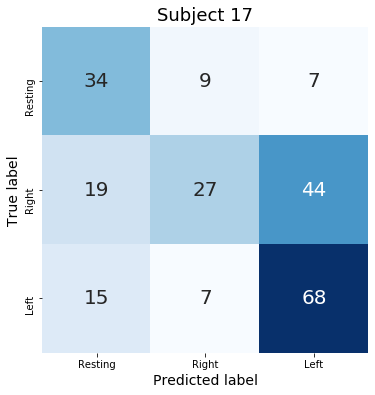

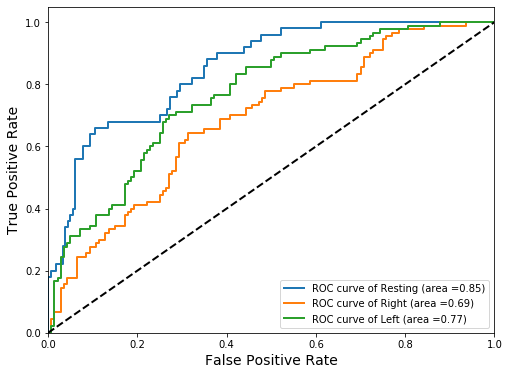

In [33]:
# Predicting the Test set results
y_pred = classifier.predict(X_scaled_test)
y_prob = classifier.decision_function(X_scaled_test)
y_test = Y_test
y_pred = y_pred
#Evaluate the model
print('---------------------')
print('SVCL classification results (subject', subjects_test[2], ')')
print('---------------------')
evaluate_model_predictions(y_test,y_pred, subjects_test[2])
plot_roc_curve(y_test,y_prob, subjects_test[2])

- Evaluate on fourth subject

In [34]:
#Select the data from the first testing subject
test_idx = features_all['Subject'] == subjects_test[3]
features_test = features_all[test_idx]
features_test.index = [features_test['Subject'], features_test['Epoch']]
X_test = features_test.drop(['Subject','Epoch','Label'], axis = 1)
Y_test = features_test['Label']
X_test.shape, Y_test.shape, Counter(Y_test)

((264, 310), (264,), Counter({1: 97, 2: 97, 0: 70}))

In [35]:
#Preprocess the data
X_test = X_test[features_names]
X_scaled_test = standardizer.transform(X_test)
X_scaled_test = normalizer.fit_transform(X_scaled_test)
X_scaled_test.shape

(264, 20)

---------------------
SVCL classification results (subject 14 )
---------------------
Total accuracy: 0.4053030303030303
------------------------------------------
Precision for resting state: 0.3624161073825503
Precision for right movement: 0.5
Precision for left movement: 0.4262295081967213
------------------------------------------
Sensitivity (true positive rate) for resting state: 0.7714285714285715
Sensitivity (true positive rate) for right movement: 0.27835051546391754
Sensitivity (true positive rate) for left movement: 0.26804123711340205
------------------------------------------
Specificity (true negative rate) for resting state: 0.5103092783505154
Specificity (true negative rate) for right movement: 0.8383233532934131
Specificity (true negative rate) for left movement: 0.7904191616766467
------------------------------------------
F1 for resting state: 0.4931506849315068
F1 for right movement: 0.3576158940397351
F1 for left movement: 0.3291139240506329
-----------------------

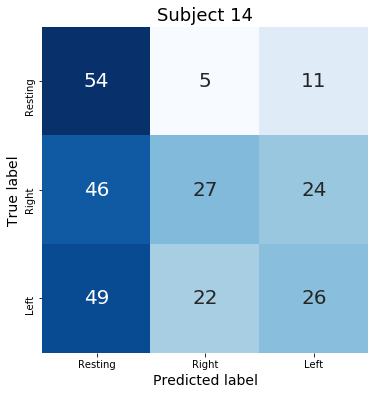

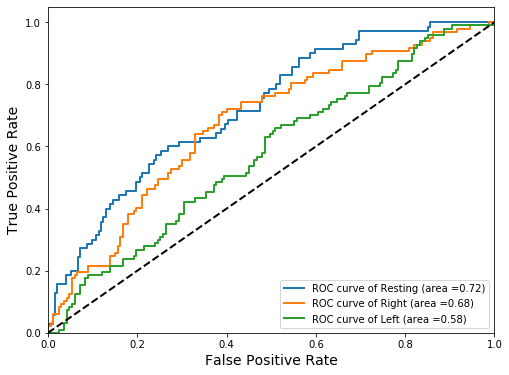

In [36]:
# Predicting the Test set results
y_pred = classifier.predict(X_scaled_test)
y_prob = classifier.decision_function(X_scaled_test)
y_test = Y_test
y_pred = y_pred
#Evaluate the model
print('---------------------')
print('SVCL classification results (subject', subjects_test[3], ')')
print('---------------------')
evaluate_model_predictions(y_test,y_pred, subjects_test[3])
plot_roc_curve(y_test,y_prob, subjects_test[3])

- Evaluate on subject five

In [37]:
#Select the data from the first testing subject
test_idx = features_all['Subject'] == subjects_test[4]
features_test = features_all[test_idx]
features_test.index = [features_test['Subject'], features_test['Epoch']]
X_test = features_test.drop(['Subject','Epoch','Label'], axis = 1)
Y_test = features_test['Label']
X_test.shape, Y_test.shape, Counter(Y_test)

((267, 310), (267,), Counter({1: 96, 2: 96, 0: 75}))

In [38]:
#Preprocess the data
X_test = X_test[features_names]
X_scaled_test = standardizer.transform(X_test)
X_scaled_test = normalizer.fit_transform(X_scaled_test)
X_scaled_test.shape

(267, 20)

---------------------
SVCL classification results (subject 9 )
---------------------
Total accuracy: 0.550561797752809
------------------------------------------
Precision for resting state: 0.460431654676259
Precision for right movement: 0.627906976744186
Precision for left movement: 0.6904761904761905
------------------------------------------
Sensitivity (true positive rate) for resting state: 0.8533333333333334
Sensitivity (true positive rate) for right movement: 0.5625
Sensitivity (true positive rate) for left movement: 0.3020833333333333
------------------------------------------
Specificity (true negative rate) for resting state: 0.609375
Specificity (true negative rate) for right movement: 0.8128654970760234
Specificity (true negative rate) for left movement: 0.9239766081871345
------------------------------------------
F1 for resting state: 0.5981308411214954
F1 for right movement: 0.5934065934065934
F1 for left movement: 0.42028985507246375
-----------------------------------

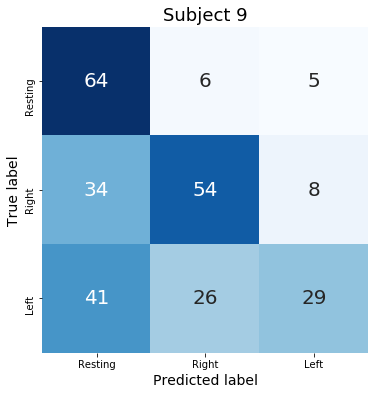

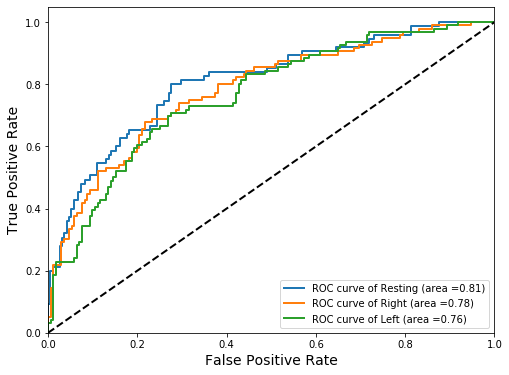

In [39]:
# Predicting the Test set results
y_pred = classifier.predict(X_scaled_test)
y_prob = classifier.decision_function(X_scaled_test)
y_test = Y_test
y_pred = y_pred
#Evaluate the model
print('---------------------')
print('SVCL classification results (subject', subjects_test[4], ')')
print('---------------------')
evaluate_model_predictions(y_test,y_pred, subjects_test[4])
plot_roc_curve(y_test,y_prob, subjects_test[4])